# Traditional ML — Tweet Harassment Detection

**Δύο προβλήματα ταξινόμησης:**
- **Part A — Binary Classification**: ανά target (harassment, SexualH, IndirectH, PhysicalH)
- **Part B — Multi-class Classification**: 4 κλάσεις (Non-harassment, IndirectH, SexualH, PhysicalH)



## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import warnings

import matplotlib
from matplotlib import pyplot as plt

import nltk
nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, RandomForestClassifier,
                               GradientBoostingClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (f1_score, classification_report,
                              confusion_matrix, make_scorer)

from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
np.random.seed(500)

## 2. Data Loading

In [3]:
train = pd.read_csv("traindata.csv")
val = pd.read_csv("Validation_data_competition.csv")
test = pd.read_csv("testdata_gold_labels.csv")

for df in [train, val, test]:
    if "Unnamed: 0" in df.columns:
        del df["Unnamed: 0"]

print(f"Train: {len(train)} samples")
print(f"Val:   {len(val)} samples")
print(f"Test:  {len(test)} samples")

Train: 6374 samples
Val:   2125 samples
Test:  2123 samples


In [4]:
train.head()

,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,pics mexican school girl naked melanie safka f...,1,0,0,1
1,RT shereiqns Having curly hair is a gotdamn ch...,0,0,0,0
2,BreakingNews 7 Unexplained Prisoners Deaths M...,0,0,0,0
3,girl dirty quarterback latino pokemon young h...,1,0,0,1
4,miliondollameat sexting n ngirl daddy n nme l...,1,0,0,1


In [5]:
val.head()

,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,RT GLOSSPHOENIX some of y all never watched co...,0,0,0,0
1,OMG CAN T BELIEVE I M DOING THIS Selling my Dr...,0,0,0,0
2,asa akira ava lauren beach sex free porn video...,1,0,0,1
3,Anyone sassy smart mouth cuuuuteeee old favor...,0,0,0,0
4,This is why you re scared of Karma you got to ...,1,0,0,1


In [6]:
test.head()

,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,is it wrong what about mezcal,0,0,0,0
1,is mkr on texts the sound you make with incaka...,0,0,0,0
2,is on now go girl bre,0,0,0,0
3,is only beaten by on anzac day eve k share which,0,0,0,0
4,is that a bowl cut on that chick,0,0,0,0


### 2a. Class Distributions — Binary Targets

In [7]:
BINARY_TARGETS = ['harassment', 'SexualH', 'IndirectH', 'PhysicalH']

print("--- Binary class distribution (Train) ---")
for col in BINARY_TARGETS:
    counts = train[col].value_counts()
    minority_pct = counts.min() / counts.sum() * 100
    print(f"  {col:12s}: {dict(counts.items())}  (minority: {minority_pct:.1f}%)")

--- Binary class distribution (Train) ---
  harassment  : {0: 3661, 1: 2713}  (minority: 42.6%)
  SexualH     : {0: 3792, 1: 2582}  (minority: 40.5%)
  IndirectH   : {0: 6319, 1: 55}  (minority: 0.9%)
  PhysicalH   : {0: 6298, 1: 76}  (minority: 1.2%)


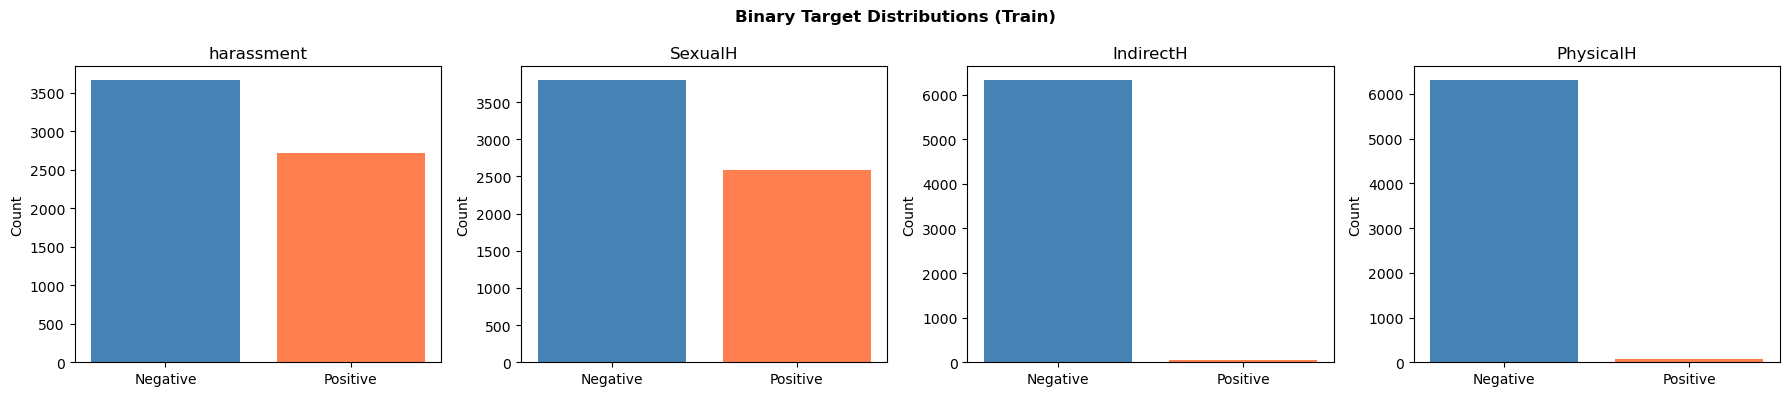

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.suptitle('Binary Target Distributions (Train)', fontweight='bold')
for ax, col in zip(axes, BINARY_TARGETS):
    counts = train[col].value_counts().sort_index()
    ax.bar(counts.index, counts.values, color=['steelblue', 'coral'])
    ax.set_title(col)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### 2b. Multi-class Label Creation

Ακολουθεί την ίδια κωδικοποίηση με το deep learning (`get_label_for_softmax`):
- 0 = Non-harassment
- 1 = Indirect Harassment
- 2 = Sexual Harassment
- 3 = Physical Harassment

In [9]:
MULTICLASS_NAMES = ['Non-harassment', 'IndirectH', 'SexualH', 'PhysicalH']

def create_multiclass_label(row):
    if row['harassment'] == 0:
        return 0
    elif row['IndirectH'] == 1:
        return 1
    elif row['SexualH'] == 1:
        return 2
    else:
        return 3

for df in [train, val, test]:
    df['multiclass'] = df.apply(create_multiclass_label, axis=1)

print("--- Multi-class distribution (Train) ---")
mc_counts = train['multiclass'].value_counts().sort_index()
for idx, count in mc_counts.items():
    print(f"  {idx} ({MULTICLASS_NAMES[idx]:16s}): {count:5d}  ({count/len(train):.1%})")

--- Multi-class distribution (Train) ---
  0 (Non-harassment  ):  3661  (57.4%)
  1 (IndirectH       ):    55  (0.9%)
  2 (SexualH         ):  2582  (40.5%)
  3 (PhysicalH       ):    76  (1.2%)


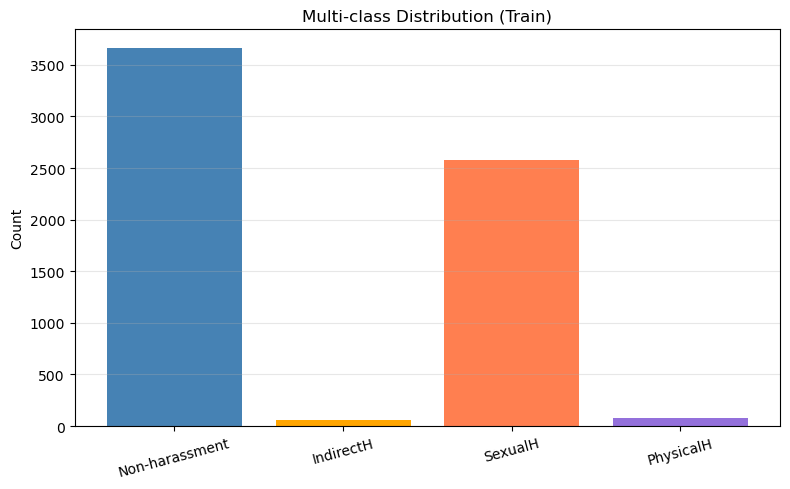

In [10]:
plt.figure(figsize=(8, 5))
mc_counts = train['multiclass'].value_counts().sort_index()
plt.bar(range(4), mc_counts.values, color=['steelblue', 'orange', 'coral', 'mediumpurple'])
plt.xticks(range(4), MULTICLASS_NAMES, rotation=15)
plt.ylabel('Count')
plt.title('Multi-class Distribution (Train)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Tweet-Specific Preprocessing

Βελτιωμένο pipeline σε σχέση με το original:
- URL / @mention αφαίρεση
- Hashtag → λέξη
- Elongated chars normalization (haaate → haate)
- Αριθμοί → NUM token
- Punctuation αφαίρεση
- Stopword αφαίρεση + Snowball stemming

In [11]:
sw_set = set(nltk_stopwords.words('english'))
stemmer = SnowballStemmer("english")

def advanced_preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # URLs
    text = re.sub(r'@\w+', '', text)                          # mentions
    text = re.sub(r'#(\w+)', r'\1', text)                    # hashtags → word
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)             # elongated chars
    text = re.sub(r'\d+', 'NUM', text)                        # numbers
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in sw_set and len(w) > 1]
    return " ".join(tokens)

for name, df in [("Train", train), ("Val", val), ("Test", test)]:
    df['tweet_clean'] = df['tweet_content'].apply(advanced_preprocess)
    print(f"  {name}: preprocessed {len(df)} tweets")

# Show examples
print("\nExamples:")
for i in range(3):
    print(f"  Original: {train['tweet_content'].iloc[i][:80]}...")
    print(f"  Cleaned:  {train['tweet_clean'].iloc[i][:80]}...")
    print()

  Train: preprocessed 6374 tweets
  Val: preprocessed 2125 tweets
  Test: preprocessed 2123 tweets

Examples:
  Original: pics mexican school girl naked melanie safka fake nude photos hardcore slut movi...
  Cleaned:  pic mexican school girl nake melani safka fake nude photo hardcor slut movi alic...

  Original: RT shereiqns Having curly hair is a gotdamn chore Do not let the internets fool ...
  Cleaned:  rt shereiqn cur hair gotdamn chore let internet fool ok...

  Original:  BreakingNews 7 Unexplained Prisoners Deaths Murder amp 50 Attempted Suicides sa...
  Cleaned:  breakingnew num unexplain prison death murder amp num attempt suicid samswey sha...



## 4. Feature Extraction

 TF-IDF fit **μόνο** σε train (no data leakage)

FeatureUnion — word bigrams (10K) + char n-grams (10K) = ~20K features

Ξεχωριστός word-only vectorizer για MultinomialNB (χρειάζεται non-negative input)

In [13]:
# Combined features: word bigrams + char n-grams
word_tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),         # unigrams + bigrams
    sublinear_tf=True,
    min_df=2,
    max_df=0.95,
    strip_accents='unicode'
)

char_tfidf = TfidfVectorizer(
    max_features=10000,
    analyzer='char_wb',
    ngram_range=(3, 5),
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)

feature_union = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])

# FIT ON TRAIN ONLY
X_train_full = feature_union.fit_transform(train['tweet_clean'])
X_val_full = feature_union.transform(val['tweet_clean'])
X_test_full = feature_union.transform(test['tweet_clean'])

print(f"Feature matrix (train): {X_train_full.shape}")
print(f"Feature matrix (val):   {X_val_full.shape}")
print(f"Feature matrix (test):  {X_test_full.shape}")
print(f"Total features: {X_train_full.shape[1]} "
      f"(word: {len(word_tfidf.get_feature_names_out())}, "
      f"char: {len(char_tfidf.get_feature_names_out())})")

Feature matrix (train): (6374, 20000)
Feature matrix (val):   (2125, 20000)
Feature matrix (test):  (2123, 20000)
Total features: 20000 (word: 10000, char: 10000)


In [14]:
# Separate word-only TF-IDF for MultinomialNB
nb_tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)
X_train_nb = nb_tfidf.fit_transform(train['tweet_clean'])
X_val_nb = nb_tfidf.transform(val['tweet_clean'])
X_test_nb = nb_tfidf.transform(test['tweet_clean'])

print(f"NB feature matrix (train): {X_train_nb.shape}")

NB feature matrix (train): (6374, 10000)


## 5. Utility Functions

In [15]:
def evaluate_model(model, X_tr, Y_tr, X_v, Y_v, X_te, Y_te,
                   model_name, target_names=None):
    """Train, predict, and print full evaluation."""
    model.fit(X_tr, Y_tr)
    pred_val = model.predict(X_v)
    pred_test = model.predict(X_te)
    f1_val = f1_score(Y_v, pred_val, average='macro')
    f1_test = f1_score(Y_te, pred_test, average='macro')

    print(f"\n  {model_name}")
    print(f"  {'─' * 55}")
    print(f"  Val  F1-macro: {f1_val:.4f}")
    print(f"  Test F1-macro: {f1_test:.4f}")

    labels = target_names if target_names else None
    print(f"\n  Test Classification Report:")
    print(classification_report(Y_te, pred_test, target_names=labels, digits=4))

    cm = confusion_matrix(Y_te, pred_test)
    print(f"  Confusion Matrix (test):")
    for row in cm:
        print(f"    {row}")

    return {'model_name': model_name, 'f1_val': f1_val, 'f1_test': f1_test,
            'pred_test': pred_test, 'model': model}


def run_gridsearch(estimator, param_grid, X_tr, Y_tr, model_name, cv=5):
    """GridSearchCV with f1_macro scoring, returns best estimator."""
    scorer = make_scorer(f1_score, average='macro')
    grid = GridSearchCV(estimator, param_grid, scoring=scorer,
                        cv=cv, n_jobs=-1, refit=True)
    grid.fit(X_tr, Y_tr)
    print(f"\n  GridSearch [{model_name}]")
    print(f"    Best params: {grid.best_params_}")
    print(f"    Best CV F1-macro: {grid.best_score_:.4f}")
    return grid.best_estimator_


def apply_smote(X_tr, Y_tr, task_name):
    """Apply SMOTE and report new class distribution."""
    sm = SMOTE(random_state=42)
    X_res, Y_res = sm.fit_resample(X_tr, Y_tr)
    unique, counts = np.unique(Y_res, return_counts=True)
    dist = dict(zip(unique.astype(int), counts))
    print(f"  SMOTE [{task_name}]: {X_tr.shape[0]} → {X_res.shape[0]} samples  {dist}")
    return X_res, Y_res

print("Utility functions defined ✓")

Utility functions defined ✓


## 6. Hyperparameter Grids

In [16]:
nb_param_grid = {
    'alpha': np.concatenate([
        np.linspace(0.001, 0.1, 10),
        np.linspace(0.1, 2.0, 10)
    ])
}

svm_linear_param_grid = {
    'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

svm_rbf_param_grid = {
    'C': [0.1, 1.0, 10.0, 50.0],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

lr_param_grid = {
    'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 30, 50],
    'min_samples_split': [2, 5]
}

print("Hyperparameter grids defined ✓")

Hyperparameter grids defined ✓


---
# PART A: Binary Classification

Ξεχωριστό μοντέλο ανά target: **harassment**, **SexualH**, **IndirectH**, **PhysicalH**

Μοντέλα: MultinomialNB, SVM-Linear, SVM-RBF, Logistic Regression, **Random Forest**, Voting Ensemble

## Part A — Target: `harassment`

In [17]:
print("=" * 70)
print("BINARY CLASSIFICATION — Target: harassment")
print("=" * 70)

Y_train = train["harassment"].to_numpy()
Y_val = val["harassment"].to_numpy()
Y_test = test["harassment"].to_numpy()

minority_ratio = Y_train.sum() / len(Y_train)
print(f"  Train balance: {Y_train.sum()}/{len(Y_train)} ({minority_ratio:.1%} positive)")

# SMOTE
X_train_sm, Y_train_sm = apply_smote(X_train_full, Y_train, "harassment")
X_train_nb_sm, Y_train_nb_sm = apply_smote(X_train_nb, Y_train, "harassment_NB")

target_names_bin = ['Non-harassment', 'harassment']
target_results_harassment = []

BINARY CLASSIFICATION — Target: harassment
  Train balance: 2713/6374 (42.6% positive)
  SMOTE [harassment]: 6374 → 7322 samples  {np.int64(0): np.int64(3661), np.int64(1): np.int64(3661)}
  SMOTE [harassment_NB]: 6374 → 7322 samples  {np.int64(0): np.int64(3661), np.int64(1): np.int64(3661)}


### MultinomialNB — `harassment`

In [18]:
best_nb = run_gridsearch(MultinomialNB(), nb_param_grid,
                          X_train_nb_sm, Y_train_nb_sm,
                          "MultinomialNB (harassment)")
res = evaluate_model(best_nb, X_train_nb_sm, Y_train_nb_sm,
                      X_val_nb, Y_val, X_test_nb, Y_test,
                      f"MultinomialNB (α={best_nb.alpha:.4f})",
                      target_names=target_names_bin)
target_results_harassment.append(res)


  GridSearch [MultinomialNB (harassment)]
    Best params: {'alpha': np.float64(2.0)}
    Best CV F1-macro: 0.8578

  MultinomialNB (α=2.0000)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.7929
  Test F1-macro: 0.7271

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8560    0.8102    0.8325      1512
    harassment     0.5853    0.6628    0.6216       611

      accuracy                         0.7678      2123
     macro avg     0.7207    0.7365    0.7271      2123
  weighted avg     0.7781    0.7678    0.7718      2123

  Confusion Matrix (test):
    [1225  287]
    [206 405]


### SVM Linear — `harassment`

In [19]:
best_svm_lin = run_gridsearch(LinearSVC(dual='auto'), svm_linear_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-Linear (harassment)")
res = evaluate_model(best_svm_lin, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-Linear (C={best_svm_lin.C})",
                      target_names=target_names_bin)
target_results_harassment.append(res)


  GridSearch [SVM-Linear (harassment)]
    Best params: {'C': 0.5}
    Best CV F1-macro: 0.8969

  SVM-Linear (C=0.5)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.8619
  Test F1-macro: 0.7344

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8178    0.9438    0.8763      1512
    harassment     0.7751    0.4795    0.5925       611

      accuracy                         0.8102      2123
     macro avg     0.7964    0.7117    0.7344      2123
  weighted avg     0.8055    0.8102    0.7946      2123

  Confusion Matrix (test):
    [1427   85]
    [318 293]


### SVM RBF — `harassment`

In [20]:
best_svm_rbf = run_gridsearch(SVC(kernel='rbf'), svm_rbf_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-RBF (harassment)")
res = evaluate_model(best_svm_rbf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-RBF (C={best_svm_rbf.C}, γ={best_svm_rbf.gamma})",
                      target_names=target_names_bin)
target_results_harassment.append(res)


  GridSearch [SVM-RBF (harassment)]
    Best params: {'C': 1.0, 'gamma': 'scale'}
    Best CV F1-macro: 0.9015

  SVM-RBF (C=1.0, γ=scale)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.8886
  Test F1-macro: 0.7199

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8036    0.9769    0.8818      1512
    harassment     0.8772    0.4092    0.5580       611

      accuracy                         0.8135      2123
     macro avg     0.8404    0.6930    0.7199      2123
  weighted avg     0.8248    0.8135    0.7886      2123

  Confusion Matrix (test):
    [1477   35]
    [361 250]


### Logistic Regression — `harassment`

In [21]:
best_lr = run_gridsearch(LogisticRegression(random_state=0), lr_param_grid,
                          X_train_sm, Y_train_sm,
                          "LogisticRegression (harassment)")
res = evaluate_model(best_lr, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"LogReg (C={best_lr.C}, pen={best_lr.penalty})",
                      target_names=target_names_bin)
target_results_harassment.append(res)


  GridSearch [LogisticRegression (harassment)]
    Best params: {'C': 5.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
    Best CV F1-macro: 0.8988

  LogReg (C=5.0, pen=l2)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.8648
  Test F1-macro: 0.7315

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8160    0.9444    0.8755      1512
    harassment     0.7748    0.4730    0.5874       611

      accuracy                         0.8088      2123
     macro avg     0.7954    0.7087    0.7315      2123
  weighted avg     0.8041    0.8088    0.7926      2123

  Confusion Matrix (test):
    [1428   84]
    [322 289]


### Random Forest — `harassment`

In [22]:
best_rf = run_gridsearch(RandomForestClassifier(random_state=0, n_jobs=-1),
                          rf_param_grid,
                          X_train_sm, Y_train_sm,
                          "RandomForest (harassment)")
res = evaluate_model(best_rf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"RandomForest (n={best_rf.n_estimators}, d={best_rf.max_depth})",
                      target_names=target_names_bin)
target_results_harassment.append(res)


  GridSearch [RandomForest (harassment)]
    Best params: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 300}
    Best CV F1-macro: 0.9090

  RandomForest (n=300, d=50)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.8982
  Test F1-macro: 0.7176

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8017    0.9815    0.8825      1512
    harassment     0.8971    0.3993    0.5527       611

      accuracy                         0.8139      2123
     macro avg     0.8494    0.6904    0.7176      2123
  weighted avg     0.8292    0.8139    0.7876      2123

  Confusion Matrix (test):
    [1484   28]
    [367 244]


### Voting Ensemble — `harassment`

In [23]:
calibrated_svm = CalibratedClassifierCV(
    LinearSVC(C=best_svm_lin.C, dual='auto'), cv=3
)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=best_lr.C, penalty=best_lr.penalty,
                                   solver='liblinear', max_iter=1000,
                                   random_state=0)),
        ('svm', calibrated_svm),
        ('rf', RandomForestClassifier(n_estimators=best_rf.n_estimators,
                                       max_depth=best_rf.max_depth,
                                       random_state=0, n_jobs=-1)),
    ],
    voting='soft'
)
res = evaluate_model(voting_clf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      "VotingEnsemble (LR+SVM+RF)",
                      target_names=target_names_bin)
target_results_harassment.append(res)


  VotingEnsemble (LR+SVM+RF)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.8778
  Test F1-macro: 0.7202

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8053    0.9683    0.8793      1512
    harassment     0.8426    0.4206    0.5611       611

      accuracy                         0.8106      2123
     macro avg     0.8240    0.6944    0.7202      2123
  weighted avg     0.8160    0.8106    0.7877      2123

  Confusion Matrix (test):
    [1464   48]
    [354 257]


### Summary — `harassment`

In [24]:
print(f"  {'─' * 60}")
print(f"  SUMMARY — Binary [harassment]")
print(f"  {'─' * 60}")
print(f"  {'Model':<45s} {'Val F1':>8s} {'Test F1':>8s}")
print(f"  {'─' * 60}")
for r in sorted(target_results_harassment, key=lambda x: x['f1_test'], reverse=True):
    marker = " ★" if r['f1_test'] == max(x['f1_test'] for x in target_results_harassment) else ""
    print(f"  {r['model_name']:<45s} {r['f1_val']:>8.4f} {r['f1_test']:>8.4f}{marker}")

  ────────────────────────────────────────────────────────────
  SUMMARY — Binary [harassment]
  ────────────────────────────────────────────────────────────
  Model                                           Val F1  Test F1
  ────────────────────────────────────────────────────────────
  SVM-Linear (C=0.5)                              0.8619   0.7344 ★
  LogReg (C=5.0, pen=l2)                          0.8648   0.7315
  MultinomialNB (α=2.0000)                        0.7929   0.7271
  VotingEnsemble (LR+SVM+RF)                      0.8778   0.7202
  SVM-RBF (C=1.0, γ=scale)                        0.8886   0.7199
  RandomForest (n=300, d=50)                      0.8982   0.7176


## Part A — Target: `SexualH`

In [25]:
print("=" * 70)
print("BINARY CLASSIFICATION — Target: SexualH")
print("=" * 70)

Y_train = train["SexualH"].to_numpy()
Y_val = val["SexualH"].to_numpy()
Y_test = test["SexualH"].to_numpy()

minority_ratio = Y_train.sum() / len(Y_train)
print(f"  Train balance: {Y_train.sum()}/{len(Y_train)} ({minority_ratio:.1%} positive)")

# SMOTE
X_train_sm, Y_train_sm = apply_smote(X_train_full, Y_train, "SexualH")
X_train_nb_sm, Y_train_nb_sm = apply_smote(X_train_nb, Y_train, "SexualH_NB")

target_names_bin = ['Non-SexualH', 'SexualH']
target_results_SexualH = []

BINARY CLASSIFICATION — Target: SexualH
  Train balance: 2582/6374 (40.5% positive)
  SMOTE [SexualH]: 6374 → 7584 samples  {np.int64(0): np.int64(3792), np.int64(1): np.int64(3792)}
  SMOTE [SexualH_NB]: 6374 → 7584 samples  {np.int64(0): np.int64(3792), np.int64(1): np.int64(3792)}


### MultinomialNB — `SexualH`

In [26]:
best_nb = run_gridsearch(MultinomialNB(), nb_param_grid,
                          X_train_nb_sm, Y_train_nb_sm,
                          "MultinomialNB (SexualH)")
res = evaluate_model(best_nb, X_train_nb_sm, Y_train_nb_sm,
                      X_val_nb, Y_val, X_test_nb, Y_test,
                      f"MultinomialNB (α={best_nb.alpha:.4f})",
                      target_names=target_names_bin)
target_results_SexualH.append(res)


  GridSearch [MultinomialNB (SexualH)]
    Best params: {'alpha': np.float64(1.788888888888889)}
    Best CV F1-macro: 0.8618

  MultinomialNB (α=1.7889)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.7868
  Test F1-macro: 0.6808

  Test Classification Report:
              precision    recall  f1-score   support

 Non-SexualH     0.9498    0.7830    0.8584      1811
     SexualH     0.3762    0.7596    0.5032       312

    accuracy                         0.7796      2123
   macro avg     0.6630    0.7713    0.6808      2123
weighted avg     0.8655    0.7796    0.8062      2123

  Confusion Matrix (test):
    [1418  393]
    [ 75 237]


### SVM Linear — `SexualH`

In [27]:
best_svm_lin = run_gridsearch(LinearSVC(dual='auto'), svm_linear_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-Linear (SexualH)")
res = evaluate_model(best_svm_lin, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-Linear (C={best_svm_lin.C})",
                      target_names=target_names_bin)
target_results_SexualH.append(res)


  GridSearch [SVM-Linear (SexualH)]
    Best params: {'C': 0.1}
    Best CV F1-macro: 0.9065

  SVM-Linear (C=0.1)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.9010
  Test F1-macro: 0.8079

  Test Classification Report:
              precision    recall  f1-score   support

 Non-SexualH     0.9413    0.9481    0.9447      1811
     SexualH     0.6856    0.6571    0.6710       312

    accuracy                         0.9053      2123
   macro avg     0.8135    0.8026    0.8079      2123
weighted avg     0.9038    0.9053    0.9045      2123

  Confusion Matrix (test):
    [1717   94]
    [107 205]


### SVM RBF — `SexualH`

In [28]:
best_svm_rbf = run_gridsearch(SVC(kernel='rbf'), svm_rbf_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-RBF (SexualH)")
res = evaluate_model(best_svm_rbf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-RBF (C={best_svm_rbf.C}, γ={best_svm_rbf.gamma})",
                      target_names=target_names_bin)
target_results_SexualH.append(res)


  GridSearch [SVM-RBF (SexualH)]
    Best params: {'C': 50.0, 'gamma': 0.01}
    Best CV F1-macro: 0.9101

  SVM-RBF (C=50.0, γ=0.01)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.8894
  Test F1-macro: 0.7972

  Test Classification Report:
              precision    recall  f1-score   support

 Non-SexualH     0.9399    0.9415    0.9407      1811
     SexualH     0.6570    0.6506    0.6538       312

    accuracy                         0.8987      2123
   macro avg     0.7984    0.7961    0.7972      2123
weighted avg     0.8983    0.8987    0.8985      2123

  Confusion Matrix (test):
    [1705  106]
    [109 203]


### Logistic Regression — `SexualH`

In [29]:
best_lr = run_gridsearch(LogisticRegression(random_state=0), lr_param_grid,
                          X_train_sm, Y_train_sm,
                          "LogisticRegression (SexualH)")
res = evaluate_model(best_lr, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"LogReg (C={best_lr.C}, pen={best_lr.penalty})",
                      target_names=target_names_bin)
target_results_SexualH.append(res)


  GridSearch [LogisticRegression (SexualH)]
    Best params: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
    Best CV F1-macro: 0.9053

  LogReg (C=1.0, pen=l2)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.9002
  Test F1-macro: 0.8096

  Test Classification Report:
              precision    recall  f1-score   support

 Non-SexualH     0.9423    0.9475    0.9449      1811
     SexualH     0.6854    0.6635    0.6743       312

    accuracy                         0.9058      2123
   macro avg     0.8139    0.8055    0.8096      2123
weighted avg     0.9046    0.9058    0.9052      2123

  Confusion Matrix (test):
    [1716   95]
    [105 207]


### Random Forest — `SexualH`

In [30]:
best_rf = run_gridsearch(RandomForestClassifier(random_state=0, n_jobs=-1),
                          rf_param_grid,
                          X_train_sm, Y_train_sm,
                          "RandomForest (SexualH)")
res = evaluate_model(best_rf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"RandomForest (n={best_rf.n_estimators}, d={best_rf.max_depth})",
                      target_names=target_names_bin)
target_results_SexualH.append(res)


  GridSearch [RandomForest (SexualH)]
    Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
    Best CV F1-macro: 0.9149

  RandomForest (n=200, d=None)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.9168
  Test F1-macro: 0.8202

  Test Classification Report:
              precision    recall  f1-score   support

 Non-SexualH     0.9383    0.9652    0.9516      1811
     SexualH     0.7577    0.6314    0.6888       312

    accuracy                         0.9162      2123
   macro avg     0.8480    0.7983    0.8202      2123
weighted avg     0.9117    0.9162    0.9129      2123

  Confusion Matrix (test):
    [1748   63]
    [115 197]


### Voting Ensemble — `SexualH`

In [31]:
calibrated_svm = CalibratedClassifierCV(
    LinearSVC(C=best_svm_lin.C, dual='auto'), cv=3
)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=best_lr.C, penalty=best_lr.penalty,
                                   solver='liblinear', max_iter=1000,
                                   random_state=0)),
        ('svm', calibrated_svm),
        ('rf', RandomForestClassifier(n_estimators=best_rf.n_estimators,
                                       max_depth=best_rf.max_depth,
                                       random_state=0, n_jobs=-1)),
    ],
    voting='soft'
)
res = evaluate_model(voting_clf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      "VotingEnsemble (LR+SVM+RF)",
                      target_names=target_names_bin)
target_results_SexualH.append(res)


  VotingEnsemble (LR+SVM+RF)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.9140
  Test F1-macro: 0.8143

  Test Classification Report:
              precision    recall  f1-score   support

 Non-SexualH     0.9380    0.9608    0.9493      1811
     SexualH     0.7351    0.6314    0.6793       312

    accuracy                         0.9124      2123
   macro avg     0.8365    0.7961    0.8143      2123
weighted avg     0.9082    0.9124    0.9096      2123

  Confusion Matrix (test):
    [1740   71]
    [115 197]


### Summary — `SexualH`

In [32]:
print(f"  {'─' * 60}")
print(f"  SUMMARY — Binary [SexualH]")
print(f"  {'─' * 60}")
print(f"  {'Model':<45s} {'Val F1':>8s} {'Test F1':>8s}")
print(f"  {'─' * 60}")
for r in sorted(target_results_SexualH, key=lambda x: x['f1_test'], reverse=True):
    marker = " ★" if r['f1_test'] == max(x['f1_test'] for x in target_results_SexualH) else ""
    print(f"  {r['model_name']:<45s} {r['f1_val']:>8.4f} {r['f1_test']:>8.4f}{marker}")

  ────────────────────────────────────────────────────────────
  SUMMARY — Binary [SexualH]
  ────────────────────────────────────────────────────────────
  Model                                           Val F1  Test F1
  ────────────────────────────────────────────────────────────
  RandomForest (n=200, d=None)                    0.9168   0.8202 ★
  VotingEnsemble (LR+SVM+RF)                      0.9140   0.8143
  LogReg (C=1.0, pen=l2)                          0.9002   0.8096
  SVM-Linear (C=0.1)                              0.9010   0.8079
  SVM-RBF (C=50.0, γ=0.01)                        0.8894   0.7972
  MultinomialNB (α=1.7889)                        0.7868   0.6808


## Part A — Target: `IndirectH`

In [33]:
print("=" * 70)
print("BINARY CLASSIFICATION — Target: IndirectH")
print("=" * 70)

Y_train = train["IndirectH"].to_numpy()
Y_val = val["IndirectH"].to_numpy()
Y_test = test["IndirectH"].to_numpy()

minority_ratio = Y_train.sum() / len(Y_train)
print(f"  Train balance: {Y_train.sum()}/{len(Y_train)} ({minority_ratio:.1%} positive)")

# SMOTE
X_train_sm, Y_train_sm = apply_smote(X_train_full, Y_train, "IndirectH")
X_train_nb_sm, Y_train_nb_sm = apply_smote(X_train_nb, Y_train, "IndirectH_NB")

target_names_bin = ['Non-IndirectH', 'IndirectH']
target_results_IndirectH = []

BINARY CLASSIFICATION — Target: IndirectH
  Train balance: 55/6374 (0.9% positive)
  SMOTE [IndirectH]: 6374 → 12638 samples  {np.int64(0): np.int64(6319), np.int64(1): np.int64(6319)}
  SMOTE [IndirectH_NB]: 6374 → 12638 samples  {np.int64(0): np.int64(6319), np.int64(1): np.int64(6319)}


### MultinomialNB — `IndirectH`

In [34]:
best_nb = run_gridsearch(MultinomialNB(), nb_param_grid,
                          X_train_nb_sm, Y_train_nb_sm,
                          "MultinomialNB (IndirectH)")
res = evaluate_model(best_nb, X_train_nb_sm, Y_train_nb_sm,
                      X_val_nb, Y_val, X_test_nb, Y_test,
                      f"MultinomialNB (α={best_nb.alpha:.4f})",
                      target_names=target_names_bin)
target_results_IndirectH.append(res)


  GridSearch [MultinomialNB (IndirectH)]
    Best params: {'alpha': np.float64(0.001)}
    Best CV F1-macro: 0.9953

  MultinomialNB (α=0.0010)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4975
  Test F1-macro: 0.4992

  Test Classification Report:
               precision    recall  f1-score   support

Non-IndirectH     0.9087    0.9865    0.9460      1926
    IndirectH     0.1875    0.0305    0.0524       197

     accuracy                         0.8978      2123
    macro avg     0.5481    0.5085    0.4992      2123
 weighted avg     0.8417    0.8978    0.8631      2123

  Confusion Matrix (test):
    [1900   26]
    [191   6]


### SVM Linear — `IndirectH`

In [35]:
best_svm_lin = run_gridsearch(LinearSVC(dual='auto'), svm_linear_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-Linear (IndirectH)")
res = evaluate_model(best_svm_lin, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-Linear (C={best_svm_lin.C})",
                      target_names=target_names_bin)
target_results_IndirectH.append(res)


  GridSearch [SVM-Linear (IndirectH)]
    Best params: {'C': 5.0}
    Best CV F1-macro: 0.9978

  SVM-Linear (C=5.0)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5034
  Test F1-macro: 0.5082

  Test Classification Report:
               precision    recall  f1-score   support

Non-IndirectH     0.9098    0.9953    0.9507      1926
    IndirectH     0.4375    0.0355    0.0657       197

     accuracy                         0.9063      2123
    macro avg     0.6737    0.5154    0.5082      2123
 weighted avg     0.8660    0.9063    0.8685      2123

  Confusion Matrix (test):
    [1917    9]
    [190   7]


### SVM RBF — `IndirectH`

In [36]:
best_svm_rbf = run_gridsearch(SVC(kernel='rbf'), svm_rbf_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-RBF (IndirectH)")
res = evaluate_model(best_svm_rbf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-RBF (C={best_svm_rbf.C}, γ={best_svm_rbf.gamma})",
                      target_names=target_names_bin)
target_results_IndirectH.append(res)


  GridSearch [SVM-RBF (IndirectH)]
    Best params: {'C': 10.0, 'gamma': 'scale'}
    Best CV F1-macro: 0.9988

  SVM-RBF (C=10.0, γ=scale)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4914
  Test F1-macro: 0.4757

  Test Classification Report:
               precision    recall  f1-score   support

Non-IndirectH     0.9072    1.0000    0.9513      1926
    IndirectH     0.0000    0.0000    0.0000       197

     accuracy                         0.9072      2123
    macro avg     0.4536    0.5000    0.4757      2123
 weighted avg     0.8230    0.9072    0.8631      2123

  Confusion Matrix (test):
    [1926    0]
    [197   0]


### Logistic Regression — `IndirectH`

In [37]:
best_lr = run_gridsearch(LogisticRegression(random_state=0), lr_param_grid,
                          X_train_sm, Y_train_sm,
                          "LogisticRegression (IndirectH)")
res = evaluate_model(best_lr, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"LogReg (C={best_lr.C}, pen={best_lr.penalty})",
                      target_names=target_names_bin)
target_results_IndirectH.append(res)


  GridSearch [LogisticRegression (IndirectH)]
    Best params: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
    Best CV F1-macro: 0.9969

  LogReg (C=10.0, pen=l2)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5146
  Test F1-macro: 0.5272

  Test Classification Report:
               precision    recall  f1-score   support

Non-IndirectH     0.9116    0.9901    0.9492      1926
    IndirectH     0.3871    0.0609    0.1053       197

     accuracy                         0.9039      2123
    macro avg     0.6493    0.5255    0.5272      2123
 weighted avg     0.8629    0.9039    0.8709      2123

  Confusion Matrix (test):
    [1907   19]
    [185  12]


### Random Forest — `IndirectH`

In [38]:
best_rf = run_gridsearch(RandomForestClassifier(random_state=0, n_jobs=-1),
                          rf_param_grid,
                          X_train_sm, Y_train_sm,
                          "RandomForest (IndirectH)")
res = evaluate_model(best_rf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"RandomForest (n={best_rf.n_estimators}, d={best_rf.max_depth})",
                      target_names=target_names_bin)
target_results_IndirectH.append(res)


  GridSearch [RandomForest (IndirectH)]
    Best params: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}
    Best CV F1-macro: 0.9979

  RandomForest (n=100, d=30)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4914
  Test F1-macro: 0.4757

  Test Classification Report:
               precision    recall  f1-score   support

Non-IndirectH     0.9072    1.0000    0.9513      1926
    IndirectH     0.0000    0.0000    0.0000       197

     accuracy                         0.9072      2123
    macro avg     0.4536    0.5000    0.4757      2123
 weighted avg     0.8230    0.9072    0.8631      2123

  Confusion Matrix (test):
    [1926    0]
    [197   0]


### Voting Ensemble — `IndirectH`

In [39]:
calibrated_svm = CalibratedClassifierCV(
    LinearSVC(C=best_svm_lin.C, dual='auto'), cv=3
)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=best_lr.C, penalty=best_lr.penalty,
                                   solver='liblinear', max_iter=1000,
                                   random_state=0)),
        ('svm', calibrated_svm),
        ('rf', RandomForestClassifier(n_estimators=best_rf.n_estimators,
                                       max_depth=best_rf.max_depth,
                                       random_state=0, n_jobs=-1)),
    ],
    voting='soft'
)
res = evaluate_model(voting_clf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      "VotingEnsemble (LR+SVM+RF)",
                      target_names=target_names_bin)
target_results_IndirectH.append(res)


  VotingEnsemble (LR+SVM+RF)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4913
  Test F1-macro: 0.4849

  Test Classification Report:
               precision    recall  f1-score   support

Non-IndirectH     0.9078    0.9969    0.9503      1926
    IndirectH     0.2500    0.0102    0.0195       197

     accuracy                         0.9053      2123
    macro avg     0.5789    0.5035    0.4849      2123
 weighted avg     0.8468    0.9053    0.8639      2123

  Confusion Matrix (test):
    [1920    6]
    [195   2]


### Summary — `IndirectH`

In [40]:
print(f"  {'─' * 60}")
print(f"  SUMMARY — Binary [IndirectH]")
print(f"  {'─' * 60}")
print(f"  {'Model':<45s} {'Val F1':>8s} {'Test F1':>8s}")
print(f"  {'─' * 60}")
for r in sorted(target_results_IndirectH, key=lambda x: x['f1_test'], reverse=True):
    marker = " ★" if r['f1_test'] == max(x['f1_test'] for x in target_results_IndirectH) else ""
    print(f"  {r['model_name']:<45s} {r['f1_val']:>8.4f} {r['f1_test']:>8.4f}{marker}")

  ────────────────────────────────────────────────────────────
  SUMMARY — Binary [IndirectH]
  ────────────────────────────────────────────────────────────
  Model                                           Val F1  Test F1
  ────────────────────────────────────────────────────────────
  LogReg (C=10.0, pen=l2)                         0.5146   0.5272 ★
  SVM-Linear (C=5.0)                              0.5034   0.5082
  MultinomialNB (α=0.0010)                        0.4975   0.4992
  VotingEnsemble (LR+SVM+RF)                      0.4913   0.4849
  SVM-RBF (C=10.0, γ=scale)                       0.4914   0.4757
  RandomForest (n=100, d=30)                      0.4914   0.4757


## Part A — Target: `PhysicalH`

In [41]:
print("=" * 70)
print("BINARY CLASSIFICATION — Target: PhysicalH")
print("=" * 70)

Y_train = train["PhysicalH"].to_numpy()
Y_val = val["PhysicalH"].to_numpy()
Y_test = test["PhysicalH"].to_numpy()

minority_ratio = Y_train.sum() / len(Y_train)
print(f"  Train balance: {Y_train.sum()}/{len(Y_train)} ({minority_ratio:.1%} positive)")

# SMOTE
X_train_sm, Y_train_sm = apply_smote(X_train_full, Y_train, "PhysicalH")
X_train_nb_sm, Y_train_nb_sm = apply_smote(X_train_nb, Y_train, "PhysicalH_NB")

target_names_bin = ['Non-PhysicalH', 'PhysicalH']
target_results_PhysicalH = []

BINARY CLASSIFICATION — Target: PhysicalH
  Train balance: 76/6374 (1.2% positive)
  SMOTE [PhysicalH]: 6374 → 12596 samples  {np.int64(0): np.int64(6298), np.int64(1): np.int64(6298)}
  SMOTE [PhysicalH_NB]: 6374 → 12596 samples  {np.int64(0): np.int64(6298), np.int64(1): np.int64(6298)}


### MultinomialNB — `PhysicalH`

In [42]:
best_nb = run_gridsearch(MultinomialNB(), nb_param_grid,
                          X_train_nb_sm, Y_train_nb_sm,
                          "MultinomialNB (PhysicalH)")
res = evaluate_model(best_nb, X_train_nb_sm, Y_train_nb_sm,
                      X_val_nb, Y_val, X_test_nb, Y_test,
                      f"MultinomialNB (α={best_nb.alpha:.4f})",
                      target_names=target_names_bin)
target_results_PhysicalH.append(res)


  GridSearch [MultinomialNB (PhysicalH)]
    Best params: {'alpha': np.float64(0.001)}
    Best CV F1-macro: 0.9943

  MultinomialNB (α=0.0010)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5324
  Test F1-macro: 0.5243

  Test Classification Report:
               precision    recall  f1-score   support

Non-PhysicalH     0.9547    0.9797    0.9671      2023
    PhysicalH     0.1277    0.0600    0.0816       100

     accuracy                         0.9364      2123
    macro avg     0.5412    0.5199    0.5243      2123
 weighted avg     0.9158    0.9364    0.9254      2123

  Confusion Matrix (test):
    [1982   41]
    [94  6]


### SVM Linear — `PhysicalH`

In [43]:
best_svm_lin = run_gridsearch(LinearSVC(dual='auto'), svm_linear_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-Linear (PhysicalH)")
res = evaluate_model(best_svm_lin, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-Linear (C={best_svm_lin.C})",
                      target_names=target_names_bin)
target_results_PhysicalH.append(res)


  GridSearch [SVM-Linear (PhysicalH)]
    Best params: {'C': 10.0}
    Best CV F1-macro: 0.9979

  SVM-Linear (C=10.0)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5431
  Test F1-macro: 0.4973

  Test Classification Report:
               precision    recall  f1-score   support

Non-PhysicalH     0.9533    0.9985    0.9754      2023
    PhysicalH     0.2500    0.0100    0.0192       100

     accuracy                         0.9520      2123
    macro avg     0.6016    0.5043    0.4973      2123
 weighted avg     0.9202    0.9520    0.9303      2123

  Confusion Matrix (test):
    [2020    3]
    [99  1]


### SVM RBF — `PhysicalH`

In [44]:
best_svm_rbf = run_gridsearch(SVC(kernel='rbf'), svm_rbf_param_grid,
                               X_train_sm, Y_train_sm,
                               "SVM-RBF (PhysicalH)")
res = evaluate_model(best_svm_rbf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"SVM-RBF (C={best_svm_rbf.C}, γ={best_svm_rbf.gamma})",
                      target_names=target_names_bin)
target_results_PhysicalH.append(res)


  GridSearch [SVM-RBF (PhysicalH)]
    Best params: {'C': 10.0, 'gamma': 'scale'}
    Best CV F1-macro: 0.9986

  SVM-RBF (C=10.0, γ=scale)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5205
  Test F1-macro: 0.4879

  Test Classification Report:
               precision    recall  f1-score   support

Non-PhysicalH     0.9529    1.0000    0.9759      2023
    PhysicalH     0.0000    0.0000    0.0000       100

     accuracy                         0.9529      2123
    macro avg     0.4764    0.5000    0.4879      2123
 weighted avg     0.9080    0.9529    0.9299      2123

  Confusion Matrix (test):
    [2023    0]
    [100   0]


### Logistic Regression — `PhysicalH`

In [45]:
best_lr = run_gridsearch(LogisticRegression(random_state=0), lr_param_grid,
                          X_train_sm, Y_train_sm,
                          "LogisticRegression (PhysicalH)")
res = evaluate_model(best_lr, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"LogReg (C={best_lr.C}, pen={best_lr.penalty})",
                      target_names=target_names_bin)
target_results_PhysicalH.append(res)


  GridSearch [LogisticRegression (PhysicalH)]
    Best params: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
    Best CV F1-macro: 0.9966

  LogReg (C=10.0, pen=l2)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5396
  Test F1-macro: 0.5062

  Test Classification Report:
               precision    recall  f1-score   support

Non-PhysicalH     0.9537    0.9975    0.9751      2023
    PhysicalH     0.2857    0.0200    0.0374       100

     accuracy                         0.9515      2123
    macro avg     0.6197    0.5088    0.5062      2123
 weighted avg     0.9222    0.9515    0.9309      2123

  Confusion Matrix (test):
    [2018    5]
    [98  2]


### Random Forest — `PhysicalH`

In [46]:
best_rf = run_gridsearch(RandomForestClassifier(random_state=0, n_jobs=-1),
                          rf_param_grid,
                          X_train_sm, Y_train_sm,
                          "RandomForest (PhysicalH)")
res = evaluate_model(best_rf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      f"RandomForest (n={best_rf.n_estimators}, d={best_rf.max_depth})",
                      target_names=target_names_bin)
target_results_PhysicalH.append(res)


  GridSearch [RandomForest (PhysicalH)]
    Best params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
    Best CV F1-macro: 0.9978

  RandomForest (n=100, d=30)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5212
  Test F1-macro: 0.4879

  Test Classification Report:
               precision    recall  f1-score   support

Non-PhysicalH     0.9529    1.0000    0.9759      2023
    PhysicalH     0.0000    0.0000    0.0000       100

     accuracy                         0.9529      2123
    macro avg     0.4764    0.5000    0.4879      2123
 weighted avg     0.9080    0.9529    0.9299      2123

  Confusion Matrix (test):
    [2023    0]
    [100   0]


### Voting Ensemble — `PhysicalH`

In [47]:
calibrated_svm = CalibratedClassifierCV(
    LinearSVC(C=best_svm_lin.C, dual='auto'), cv=3
)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=best_lr.C, penalty=best_lr.penalty,
                                   solver='liblinear', max_iter=1000,
                                   random_state=0)),
        ('svm', calibrated_svm),
        ('rf', RandomForestClassifier(n_estimators=best_rf.n_estimators,
                                       max_depth=best_rf.max_depth,
                                       random_state=0, n_jobs=-1)),
    ],
    voting='soft'
)
res = evaluate_model(voting_clf, X_train_sm, Y_train_sm,
                      X_val_full, Y_val, X_test_full, Y_test,
                      "VotingEnsemble (LR+SVM+RF)",
                      target_names=target_names_bin)
target_results_PhysicalH.append(res)


  VotingEnsemble (LR+SVM+RF)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.5457
  Test F1-macro: 0.4977

  Test Classification Report:
               precision    recall  f1-score   support

Non-PhysicalH     0.9533    0.9995    0.9759      2023
    PhysicalH     0.5000    0.0100    0.0196       100

     accuracy                         0.9529      2123
    macro avg     0.7267    0.5048    0.4977      2123
 weighted avg     0.9320    0.9529    0.9308      2123

  Confusion Matrix (test):
    [2022    1]
    [99  1]


### Summary — `PhysicalH`

In [48]:
print(f"  {'─' * 60}")
print(f"  SUMMARY — Binary [PhysicalH]")
print(f"  {'─' * 60}")
print(f"  {'Model':<45s} {'Val F1':>8s} {'Test F1':>8s}")
print(f"  {'─' * 60}")
for r in sorted(target_results_PhysicalH, key=lambda x: x['f1_test'], reverse=True):
    marker = " ★" if r['f1_test'] == max(x['f1_test'] for x in target_results_PhysicalH) else ""
    print(f"  {r['model_name']:<45s} {r['f1_val']:>8.4f} {r['f1_test']:>8.4f}{marker}")

  ────────────────────────────────────────────────────────────
  SUMMARY — Binary [PhysicalH]
  ────────────────────────────────────────────────────────────
  Model                                           Val F1  Test F1
  ────────────────────────────────────────────────────────────
  MultinomialNB (α=0.0010)                        0.5324   0.5243 ★
  LogReg (C=10.0, pen=l2)                         0.5396   0.5062
  VotingEnsemble (LR+SVM+RF)                      0.5457   0.4977
  SVM-Linear (C=10.0)                             0.5431   0.4973
  SVM-RBF (C=10.0, γ=scale)                       0.5205   0.4879
  RandomForest (n=100, d=30)                      0.5212   0.4879


## Part A — Overall Binary Summary

In [49]:
all_binary_results = {
    'harassment': target_results_harassment,
    'SexualH': target_results_SexualH,
    'IndirectH': target_results_IndirectH,
    'PhysicalH': target_results_PhysicalH
}

print("\nBest model per binary target:")
print("─" * 65)
for target_col, results in all_binary_results.items():
    best = max(results, key=lambda x: x['f1_test'])
    print(f"  {target_col:12s} → {best['model_name']:<40s} Test F1: {best['f1_test']:.4f}")


Best model per binary target:
─────────────────────────────────────────────────────────────────
  harassment   → SVM-Linear (C=0.5)                       Test F1: 0.7344
  SexualH      → RandomForest (n=200, d=None)             Test F1: 0.8202
  IndirectH    → LogReg (C=10.0, pen=l2)                  Test F1: 0.5272
  PhysicalH    → MultinomialNB (α=0.0010)                 Test F1: 0.5243


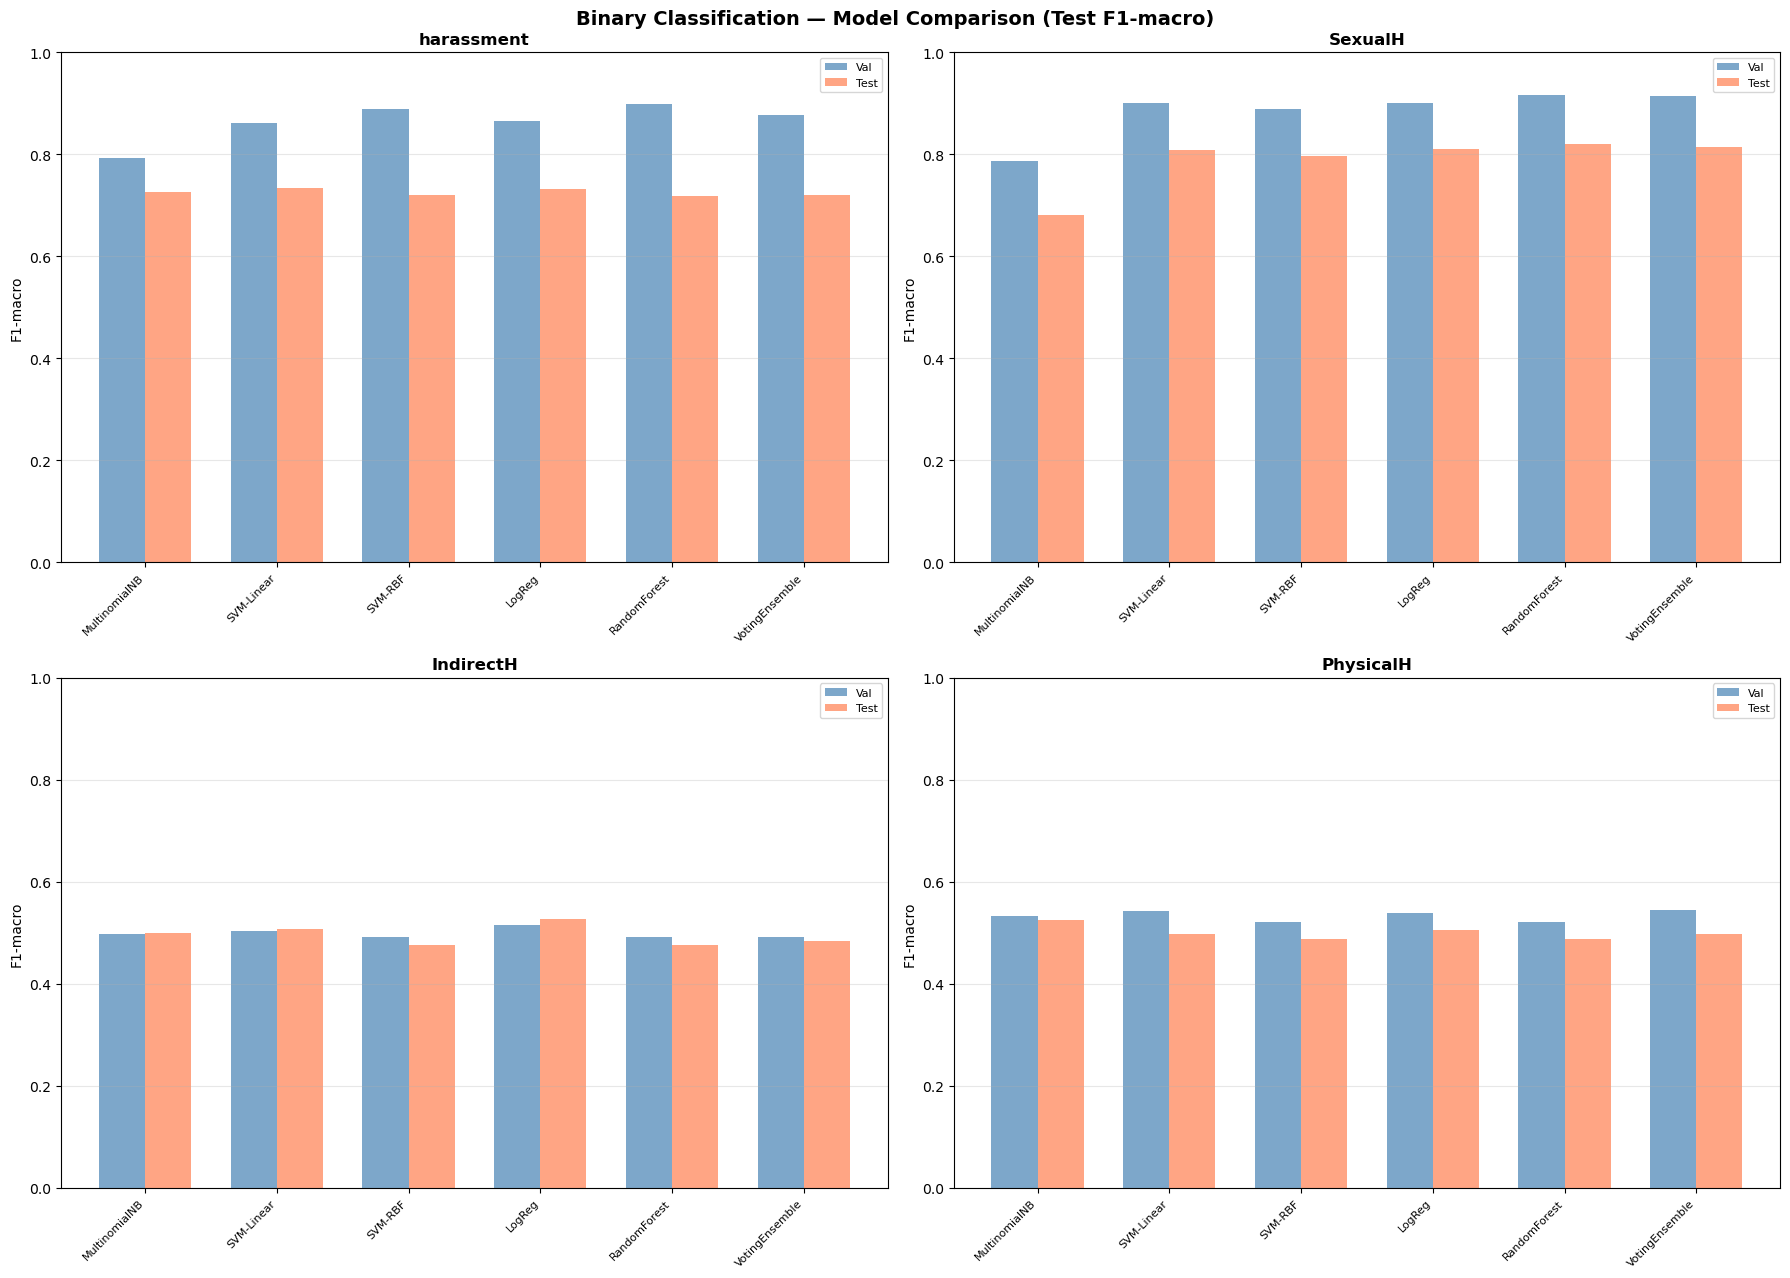

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
fig.suptitle('Binary Classification — Model Comparison (Test F1-macro)',
             fontsize=14, fontweight='bold')

for ax, target_col in zip(axes.flatten(), BINARY_TARGETS):
    results = all_binary_results[target_col]
    names = [r['model_name'].split('(')[0].strip() for r in results]
    f1_vals = [r['f1_val'] for r in results]
    f1_tests = [r['f1_test'] for r in results]

    x = np.arange(len(names))
    width = 0.35
    ax.bar(x - width/2, f1_vals, width, label='Val', alpha=0.7, color='steelblue')
    ax.bar(x + width/2, f1_tests, width, label='Test', alpha=0.7, color='coral')
    ax.set_ylabel('F1-macro')
    ax.set_title(target_col, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# PART B: Multi-class Classification

**4 κλάσεις** (ίδια κωδικοποίηση με το deep learning `get_label_for_softmax`):
- 0 = Non-harassment
- 1 = Indirect Harassment
- 2 = Sexual Harassment
- 3 = Physical Harassment

## Multi-class — Data Preparation & SMOTE

In [51]:
Y_train_mc = train['multiclass'].to_numpy()
Y_val_mc = val['multiclass'].to_numpy()
Y_test_mc = test['multiclass'].to_numpy()

print("Train distribution:")
for cls_idx, cls_name in enumerate(MULTICLASS_NAMES):
    n = (Y_train_mc == cls_idx).sum()
    print(f"  {cls_idx} ({cls_name:16s}): {n:5d} ({n/len(Y_train_mc):.1%})")

X_train_mc_sm, Y_train_mc_sm = apply_smote(X_train_full, Y_train_mc, "multiclass")
X_train_mc_nb_sm, Y_train_mc_nb_sm = apply_smote(X_train_nb, Y_train_mc, "multiclass_NB")

multiclass_results = []

Train distribution:
  0 (Non-harassment  ):  3661 (57.4%)
  1 (IndirectH       ):    55 (0.9%)
  2 (SexualH         ):  2582 (40.5%)
  3 (PhysicalH       ):    76 (1.2%)
  SMOTE [multiclass]: 6374 → 14644 samples  {np.int64(0): np.int64(3661), np.int64(1): np.int64(3661), np.int64(2): np.int64(3661), np.int64(3): np.int64(3661)}
  SMOTE [multiclass_NB]: 6374 → 14644 samples  {np.int64(0): np.int64(3661), np.int64(1): np.int64(3661), np.int64(2): np.int64(3661), np.int64(3): np.int64(3661)}


### MultinomialNB — Multi-class

In [52]:
best_nb_mc = run_gridsearch(MultinomialNB(), nb_param_grid,
                             X_train_mc_nb_sm, Y_train_mc_sm,
                             "MultinomialNB (multiclass)")
res = evaluate_model(best_nb_mc, X_train_mc_nb_sm, Y_train_mc_sm,
                      X_val_nb, Y_val_mc, X_test_nb, Y_test_mc,
                      f"MultinomialNB (α={best_nb_mc.alpha:.4f})",
                      target_names=MULTICLASS_NAMES)
multiclass_results.append(res)


  GridSearch [MultinomialNB (multiclass)]
    Best params: {'alpha': np.float64(0.023000000000000003)}
    Best CV F1-macro: 0.9139

  MultinomialNB (α=0.0230)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.3998
  Test F1-macro: 0.3597

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8168    0.7963    0.8064      1512
     IndirectH     0.2000    0.0406    0.0675       197
       SexualH     0.3698    0.6603    0.4741       312
     PhysicalH     0.1346    0.0686    0.0909       102

      accuracy                         0.6712      2123
     macro avg     0.3803    0.3914    0.3597      2123
  weighted avg     0.6611    0.6712    0.6546      2123

  Confusion Matrix (test):
    [1204   30  241   37]
    [119   8  68   2]
    [ 98   2 206   6]
    [53  0 42  7]


### SVM Linear — Multi-class

In [53]:
best_svm_lin_mc = run_gridsearch(LinearSVC(dual='auto'), svm_linear_param_grid,
                                  X_train_mc_sm, Y_train_mc_sm,
                                  "SVM-Linear (multiclass)")
res = evaluate_model(best_svm_lin_mc, X_train_mc_sm, Y_train_mc_sm,
                      X_val_full, Y_val_mc, X_test_full, Y_test_mc,
                      f"SVM-Linear (C={best_svm_lin_mc.C})",
                      target_names=MULTICLASS_NAMES)
multiclass_results.append(res)


  GridSearch [SVM-Linear (multiclass)]
    Best params: {'C': 1.0}
    Best CV F1-macro: 0.9486

  SVM-Linear (C=1.0)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4468
  Test F1-macro: 0.4126

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8153    0.9345    0.8709      1512
     IndirectH     0.5200    0.0660    0.1171       197
       SexualH     0.5718    0.6506    0.6087       312
     PhysicalH     0.3000    0.0294    0.0536       102

      accuracy                         0.7687      2123
     macro avg     0.5518    0.4201    0.4126      2123
  weighted avg     0.7274    0.7687    0.7231      2123

  Confusion Matrix (test):
    [1413   10   85    4]
    [147  13  34   3]
    [107   2 203   0]
    [66  0 33  3]


### SVM RBF — Multi-class

In [54]:
best_svm_rbf_mc = run_gridsearch(SVC(kernel='rbf'), svm_rbf_param_grid,
                                  X_train_mc_sm, Y_train_mc_sm,
                                  "SVM-RBF (multiclass)")
res = evaluate_model(best_svm_rbf_mc, X_train_mc_sm, Y_train_mc_sm,
                      X_val_full, Y_val_mc, X_test_full, Y_test_mc,
                      f"SVM-RBF (C={best_svm_rbf_mc.C}, γ={best_svm_rbf_mc.gamma})",
                      target_names=MULTICLASS_NAMES)
multiclass_results.append(res)


  GridSearch [SVM-RBF (multiclass)]
    Best params: {'C': 50.0, 'gamma': 0.01}
    Best CV F1-macro: 0.9526

  SVM-RBF (C=50.0, γ=0.01)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4600
  Test F1-macro: 0.4027

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8097    0.9537    0.8758      1512
     IndirectH     0.3750    0.0305    0.0563       197
       SexualH     0.6324    0.6506    0.6414       312
     PhysicalH     0.4000    0.0196    0.0374       102

      accuracy                         0.7786      2123
     macro avg     0.5543    0.4136    0.4027      2123
  weighted avg     0.7236    0.7786    0.7250      2123

  Confusion Matrix (test):
    [1442    8   59    3]
    [159   6  32   0]
    [107   2 203   0]
    [73  0 27  2]


### Logistic Regression (Multinomial) — Multi-class

In [55]:
best_lr_mc = run_gridsearch(
    LogisticRegression(random_state=0, multi_class='multinomial',
                       solver='lbfgs', max_iter=1000),
    {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
    X_train_mc_sm, Y_train_mc_sm,
    "LogisticRegression (multiclass)")
res = evaluate_model(best_lr_mc, X_train_mc_sm, Y_train_mc_sm,
                      X_val_full, Y_val_mc, X_test_full, Y_test_mc,
                      f"LogReg-Multinomial (C={best_lr_mc.C})",
                      target_names=MULTICLASS_NAMES)
multiclass_results.append(res)


  GridSearch [LogisticRegression (multiclass)]
    Best params: {'C': 5.0}
    Best CV F1-macro: 0.9478

  LogReg-Multinomial (C=5.0)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4643
  Test F1-macro: 0.4218

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8134    0.9339    0.8695      1512
     IndirectH     0.4324    0.0812    0.1368       197
       SexualH     0.5928    0.6346    0.6130       312
     PhysicalH     0.2500    0.0392    0.0678       102

      accuracy                         0.7678      2123
     macro avg     0.5222    0.4222    0.4218      2123
  weighted avg     0.7185    0.7678    0.7253      2123

  Confusion Matrix (test):
    [1412   17   77    6]
    [148  16  28   5]
    [109   4 198   1]
    [67  0 31  4]


### Random Forest — Multi-class

In [56]:
best_rf_mc = run_gridsearch(RandomForestClassifier(random_state=0, n_jobs=-1),
                             rf_param_grid,
                             X_train_mc_sm, Y_train_mc_sm,
                             "RandomForest (multiclass)")
res = evaluate_model(best_rf_mc, X_train_mc_sm, Y_train_mc_sm,
                      X_val_full, Y_val_mc, X_test_full, Y_test_mc,
                      f"RandomForest (n={best_rf_mc.n_estimators}, d={best_rf_mc.max_depth})",
                      target_names=MULTICLASS_NAMES)
multiclass_results.append(res)


  GridSearch [RandomForest (multiclass)]
    Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
    Best CV F1-macro: 0.9551

  RandomForest (n=200, d=None)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4659
  Test F1-macro: 0.3889

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.7959    0.9828    0.8796      1512
     IndirectH     0.0000    0.0000    0.0000       197
       SexualH     0.7500    0.6154    0.6761       312
     PhysicalH     0.0000    0.0000    0.0000       102

      accuracy                         0.7904      2123
     macro avg     0.3865    0.3995    0.3889      2123
  weighted avg     0.6771    0.7904    0.7258      2123

  Confusion Matrix (test):
    [1486    0   26    0]
    [183   0  14   0]
    [120   0 192   0]
    [78  0 24  0]


### Voting Ensemble — Multi-class

In [57]:
calibrated_svm_mc = CalibratedClassifierCV(
    LinearSVC(C=best_svm_lin_mc.C, dual='auto'), cv=3
)
voting_clf_mc = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=best_lr_mc.C, multi_class='multinomial',
                                   solver='lbfgs', max_iter=1000, random_state=0)),
        ('svm', calibrated_svm_mc),
        ('rf', RandomForestClassifier(n_estimators=best_rf_mc.n_estimators,
                                       max_depth=best_rf_mc.max_depth,
                                       random_state=0, n_jobs=-1)),
    ],
    voting='soft'
)
res = evaluate_model(voting_clf_mc, X_train_mc_sm, Y_train_mc_sm,
                      X_val_full, Y_val_mc, X_test_full, Y_test_mc,
                      "VotingEnsemble (LR+SVM+RF)",
                      target_names=MULTICLASS_NAMES)
multiclass_results.append(res)


  VotingEnsemble (LR+SVM+RF)
  ───────────────────────────────────────────────────────
  Val  F1-macro: 0.4622
  Test F1-macro: 0.3985

  Test Classification Report:
                precision    recall  f1-score   support

Non-harassment     0.8038    0.9676    0.8782      1512
     IndirectH     0.4167    0.0254    0.0478       197
       SexualH     0.6747    0.6250    0.6489       312
     PhysicalH     0.5000    0.0098    0.0192       102

      accuracy                         0.7838      2123
     macro avg     0.5988    0.4069    0.3985      2123
  weighted avg     0.7343    0.7838    0.7261      2123

  Confusion Matrix (test):
    [1463    5   43    1]
    [168   5  24   0]
    [115   2 195   0]
    [74  0 27  1]


## Multi-class Summary

In [58]:
print(f"{'─' * 60}")
print(f"SUMMARY — Multi-class")
print(f"{'─' * 60}")
print(f"{'Model':<45s} {'Val F1':>8s} {'Test F1':>8s}")
print(f"{'─' * 60}")
for r in sorted(multiclass_results, key=lambda x: x['f1_test'], reverse=True):
    marker = " ★" if r['f1_test'] == max(x['f1_test'] for x in multiclass_results) else ""
    print(f"{r['model_name']:<45s} {r['f1_val']:>8.4f} {r['f1_test']:>8.4f}{marker}")

────────────────────────────────────────────────────────────
SUMMARY — Multi-class
────────────────────────────────────────────────────────────
Model                                           Val F1  Test F1
────────────────────────────────────────────────────────────
LogReg-Multinomial (C=5.0)                      0.4643   0.4218 ★
SVM-Linear (C=1.0)                              0.4468   0.4126
SVM-RBF (C=50.0, γ=0.01)                        0.4600   0.4027
VotingEnsemble (LR+SVM+RF)                      0.4622   0.3985
RandomForest (n=200, d=None)                    0.4659   0.3889
MultinomialNB (α=0.0230)                        0.3998   0.3597


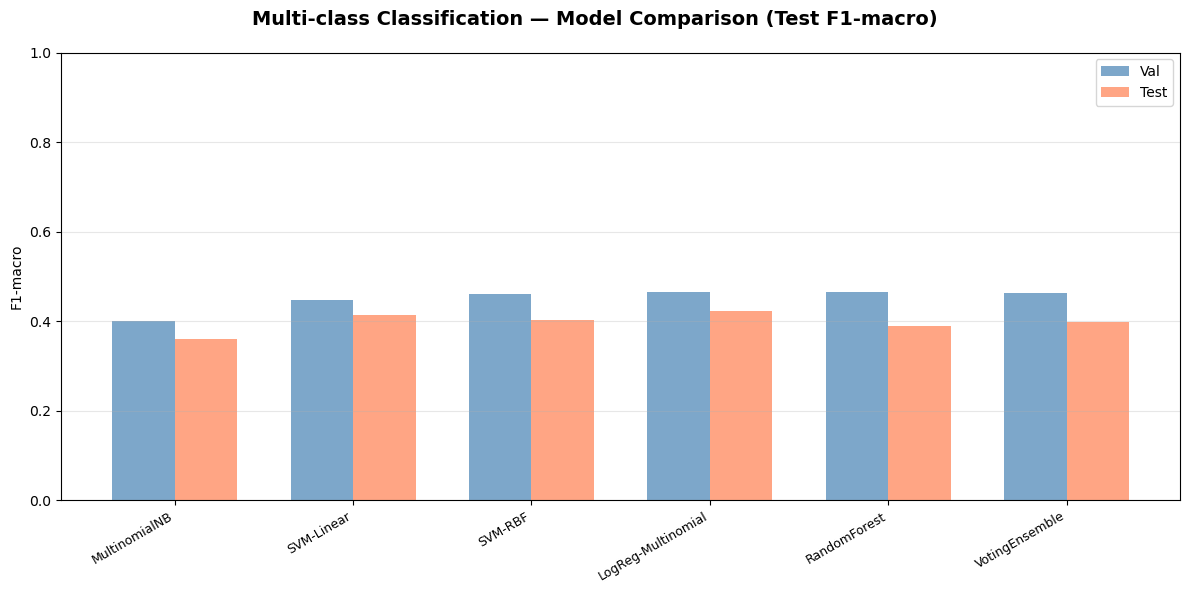

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Multi-class Classification — Model Comparison (Test F1-macro)',
             fontsize=14, fontweight='bold')

names = [r['model_name'].split('(')[0].strip() for r in multiclass_results]
f1_vals = [r['f1_val'] for r in multiclass_results]
f1_tests = [r['f1_test'] for r in multiclass_results]

x = np.arange(len(names))
width = 0.35
ax.bar(x - width/2, f1_vals, width, label='Val', alpha=0.7, color='steelblue')
ax.bar(x + width/2, f1_tests, width, label='Test', alpha=0.7, color='coral')
ax.set_ylabel('F1-macro')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha='right', fontsize=9)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## Overall Summary — Best Models

In [60]:
print("=" * 70)
print("OVERALL BEST MODELS")
print("=" * 70)

summary_rows = []

print("\n  Binary Classification:")
for target_col, results in all_binary_results.items():
    best = max(results, key=lambda x: x['f1_test'])
    print(f"    {target_col:12s} → {best['model_name']:<40s} Test F1: {best['f1_test']:.4f}")
    summary_rows.append({'problem': 'binary', 'target': target_col,
                         'best_model': best['model_name'],
                         'f1_val': best['f1_val'], 'f1_test': best['f1_test']})

best_mc = max(multiclass_results, key=lambda x: x['f1_test'])
print(f"\n  Multi-class Classification:")
print(f"    4-class      → {best_mc['model_name']:<40s} Test F1: {best_mc['f1_test']:.4f}")
summary_rows.append({'problem': 'multiclass', 'target': '4-class',
                     'best_model': best_mc['model_name'],
                     'f1_val': best_mc['f1_val'], 'f1_test': best_mc['f1_test']})

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("results_summary.csv", index=False)
print("\nResults saved to results_summary.csv")
summary_df

OVERALL BEST MODELS

  Binary Classification:
    harassment   → SVM-Linear (C=0.5)                       Test F1: 0.7344
    SexualH      → RandomForest (n=200, d=None)             Test F1: 0.8202
    IndirectH    → LogReg (C=10.0, pen=l2)                  Test F1: 0.5272
    PhysicalH    → MultinomialNB (α=0.0010)                 Test F1: 0.5243

  Multi-class Classification:
    4-class      → LogReg-Multinomial (C=5.0)               Test F1: 0.4218

Results saved to results_summary.csv


,problem,target,best_model,f1_val,f1_test
0,binary,harassment,SVM-Linear (C=0.5),0.861862,0.734392
1,binary,SexualH,"RandomForest (n=200, d=None)",0.916763,0.820181
2,binary,IndirectH,"LogReg (C=10.0, pen=l2)",0.514617,0.527246
3,binary,PhysicalH,MultinomialNB (α=0.0010),0.532399,0.524349
4,multiclass,4-class,LogReg-Multinomial (C=5.0),0.464285,0.421752
